In [ ]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/aiken516/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

import time

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 382 (delta 21), reused 24 (delta 9), pack-reused 340
Receiving objects: 100% (382/382), 45.35 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (219/219), done.
renamed 'one-pixel-attack-keras/1_one_pixel_attack_cifar10.ipynb' -> './1_one_pixel_attack_cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './LI

###Load Data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

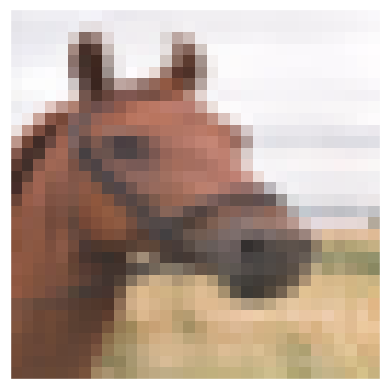

[199 178 127]


In [ ]:
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])
horse_img=x_test[image_id]
print(horse_img[31,31])

###Perturb Image


In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

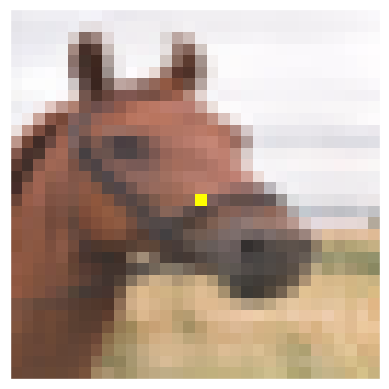

In [ ]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

###Load Models

In [ ]:
# Should output /device:GPU:0
# K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

tf.test.gpu_device_name()

''

In [ ]:
lenet = LeNet()
resnet = ResNet()
# densenet = DenseNet()
models = [lenet, resnet]
# models = [lenet, resnet, densenet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet




###Sensitive Pixel Sorting

In [ ]:
def sensitive_pixel_sorting(image_id):
    img = x_test[image_id].copy()
    target_class = y_test[image_id, 0]

    diff_list = [[0,0,0]]

    prior_confidence =  model.predict_one(img)[target_class]

    rgb = [0, 0, 0]

    for x in range(32):
        for y in range(32):

          for i in range(3):
              if img[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img)

          after_confidence =  model.predict_one(perturbed_image)[target_class]
          diff_confidence = abs(after_confidence - prior_confidence)

          if diff_confidence > 0:
              for diff_index in range(len(diff_list)):
                  if diff_confidence >= diff_list[diff_index][2]:
                      diff_list.insert(diff_index, [x, y, diff_confidence])
                      if (len(diff_list) > 30):
                          diff_list.pop()
                      break
    return diff_list

In [ ]:
image_id = 99
model=resnet
print(sensitive_pixel_sorting(image_id)[0])

1/1 [==============================] - 0s 30ms/step
[17, 16, 1.1920929e-07]


#pixel color 하나만 바꾸기

c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 38ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 38ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 31ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 35ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 34ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 34ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 34ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 31ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 42ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 32ms/step
c1 138
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 36ms/step
c1 138
<class 'numpy.ndarray'>
b

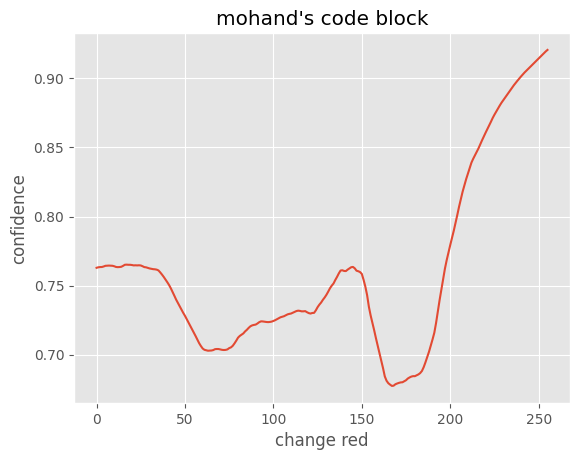

c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 42ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 51ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 37ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 37ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 32ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 32ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 30ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 34ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 36ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 64ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 51ms/step
c1 159
<class 'numpy.ndarray'>
b

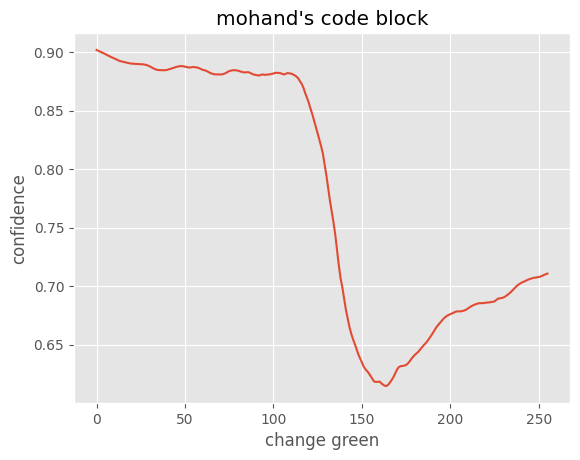

c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 41ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 47ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 57ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 60ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 53ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 58ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 53ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 32ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 35ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 30ms/step
c1 159
<class 'numpy.ndarray'>
bird
1/1 [==============================] - 0s 37ms/step
c1 159
<class 'numpy.ndarray'>
b

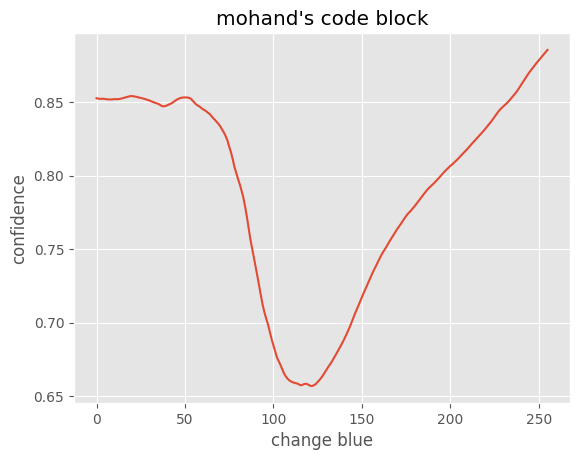

In [ ]:
 from matplotlib import pyplot as plt
import numpy as np
image_id = 384
def change_one_color(model,image_id,x,y,rgb,color_range):
  #change red color
  if (rgb==0): #0이면 r
    c1_idx=1
    c2_idx=2
  if (rgb==1): #1이면 g
    c1_idx=0
    c2_idx=2
  if (rgb==2): #2이면 b
    c1_idx=0
    c2_idx=1

  img = x_test[image_id]
  c1=img[x][y][c1_idx]
  print("c1",c1)
  c2=img[x][y][c2_idx]
  if(rgb==0):
    pixel=np.array([x,y,color_range,c1,c2])
  if(rgb==1):
    pixel=np.array([x,y,c1,color_range,c2])
  if(rgb==2):
    pixel=np.array([x,y,c1,c2,color_range])

  print(type(pixel))
  changed_image=perturb_image(pixel,x_test[image_id])[0]


  true_class = y_test[image_id, 0]
  print(class_names[true_class])

  previous_probs=model.predict_one(img)[true_class]
  previous_probs_class=model.predict_one(changed_image)[true_class]
  predicted_probs=model.predict_one(changed_image)[true_class]
  predicted_probs_class=model.predict_one(changed_image)[true_class]

  # print("previous_probs:",previous_probs)
  # print("previous_probs_class:",previous_probs_class)
  # print("predicted_probs",predicted_probs)
  # print("predicted_probs_class",predicted_probs_class)

  return predicted_probs

x=16
y=17

X=np.arange(0,256)
Y_list=[]
rgb_list=["red","green","blue"]
model=resnet
rgb=0
for rgb in range(0,3):
  Y_list=[]
  for one_color_range in range(0,256):
    changed_confidence=change_one_color(model,image_id,x,y,rgb,one_color_range)
    Y_list.append(changed_confidence)
  Y=np.array(Y_list)
  plt.plot(X, Y)
  plt.title("mohand's code block")
  plt.xlabel("change "+rgb_list[rgb])
  plt.ylabel("confidence")
  plt.show()






  # attack_image = perturb_image(np.array(result_x), x_test[image_id])[0]
  # predicted_probs = model.predict_one(attack_image)
  # predicted_class = np.argmax(predicted_probs)
  # actual_class = y_test[image_id, 0]
  # helper.plot_image(attack_image, actual_class, class_names, predicted_class)

###pixel color 두 개 바꾸기

<class 'numpy.ndarray'>
Shape of z: (100, 100)
Z values:
[[50.         49.00010203 48.02061014 ... 48.02061014 49.00010203
  50.        ]
 [49.00010203 48.00020406 47.02071217 ... 47.02071217 48.00020406
  49.00010203]
 [48.02061014 47.02071217 46.04122028 ... 46.04122028 47.02071217
  48.02061014]
 ...
 [48.02061014 47.02071217 46.04122028 ... 46.04122028 47.02071217
  48.02061014]
 [49.00010203 48.00020406 47.02071217 ... 47.02071217 48.00020406
  49.00010203]
 [50.         49.00010203 48.02061014 ... 48.02061014 49.00010203
  50.        ]]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


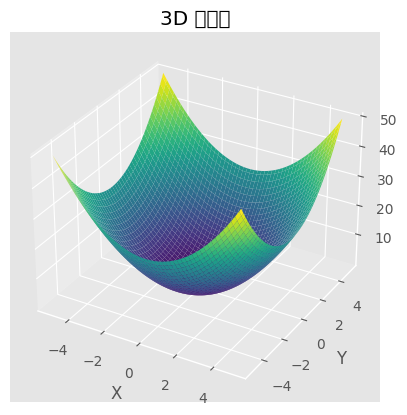

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# (x, y) 격자점 생성
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)

# 3차원 함수 생성 (여기에서는 z = x^2 + y^2로 가정)
z = x**2 + y**2

# 3차원 함수 값 출력
print(type(z))
print("Shape of z:", z.shape)
print("Z values:")
print(z)

# 3D 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D 그래프 그리기
ax.plot_surface(x, y, z, cmap='viridis')

# 라벨 및 제목 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D 그래프')

# 그래프 표시
plt.show()

1/1 [==============================] - 0s 48ms/step
0.40691724
1/1 [==============================] - 0s 35ms/step
0.40691724
1/1 [==============================] - 0s 33ms/step
0.47346216
1/1 [==============================] - 0s 32ms/step
0.47346216
1/1 [==============================] - 0s 32ms/step
0.5372903
1/1 [==============================] - 0s 33ms/step
0.5372903
1/1 [==============================] - 0s 31ms/step
0.59754
1/1 [==============================] - 0s 43ms/step
0.59754
1/1 [==============================] - 0s 48ms/step
0.66392326
1/1 [==============================] - 0s 30ms/step
0.66392326
1/1 [==============================] - 0s 46ms/step
0.72285885
1/1 [==============================] - 0s 32ms/step
0.72285885
1/1 [==============================] - 0s 31ms/step
0.76630646
1/1 [==============================] - 0s 36ms/step
0.76630646
1/1 [==============================] - 0s 32ms/step
0.79295075
1/1 [==============================] - 0s 38ms/step
0.79295075


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


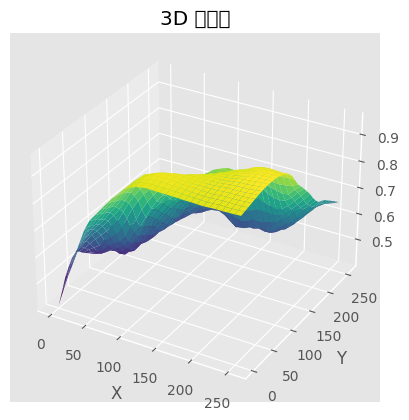

In [ ]:
 from tensorflow.python.ops.gen_nn_ops import conv2d_eager_fallback
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def change_two_color(model,image_id,x,y,c1,c2,fixed_color):
  #change two color
  #c1은 red값 c2는 green값
  img = x_test[image_id]
  fixed_red=img[x][y][0]
  fixed_green=img[x][y][1]
  # fixed_blue=img[x][y][2]
  fixed_blue=0
  pixel=None
  if fixed_color=="red":
    pixel=np.array([x,y,fixed_red,c1,c2])
  if fixed_color=="green":
    pixel=np.array([x,y,c1,fixed_green,c2])
  if fixed_color=="blue":
    pixel=np.array([x,y,c1,c2,fixed_blue])
  changed_image=perturb_image(pixel,x_test[image_id])[0]
  true_class = y_test[image_id, 0]
  predicted_probs=model.predict_one(changed_image)[true_class]
  print(predicted_probs)
  return predicted_probs




# (x, y) 격자점 생성
x = np.linspace(0, 256, 32)
y = np.linspace(0, 256, 32)
x, y = np.meshgrid(x, y)

# 3차원 함수 생성 (여기에서는 z = x^2 + y^2로 가정)
model=resnet
image_id = 384

x_point=16
y_point=17
z=[]

for c2 in range(0,256,8):
  z_prime=[]
  for c1 in range(0,256,8):
    confidence=change_two_color(model,image_id,x_point,y_point,c1,c2,"blue")
    z_prime.append(change_two_color(model,image_id,x_point,y_point,c1,c2,"blue"))
  print(z_prime)
  z.append(z_prime)


z=np.array(z)
print("Shape of z:", z.shape)
print("Z values:")
print(z)

# 3D 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D 그래프 그리기
ax.plot_surface(x, y, z, cmap='viridis')

# 라벨 및 제목 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D 그래프')

print("x shape:", x.shape)
print("y shape:", y.shape)
print("z shape:", z.shape)
print("z values:")
print(z)

# 그래프 표시
plt.show()

fixed_red: 228
fixed_green: 222
fixed_blue: 220
y_test:[5]
true_class : 5
1/1 [==============================] - 0s 32ms/step
confidence score:[2.5544487e-09 7.1114412e-09 3.4082087e-10 8.9894684e-08 1.7182424e-10
 9.9990606e-01 5.5566779e-10 9.3887516e-05 4.2308890e-09 3.6563159e-09]


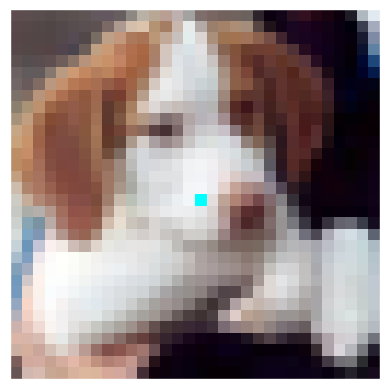

In [ ]:
image_id = 16 # Image index in the test
img = x_test[image_id]
fixed_green=img[16][17][1]
fixed_red=img[16][17][0]
fixed_blue=img[16][17][2]

print(f"fixed_red: {fixed_red}")
print(f"fixed_green: {fixed_green}")
print(f"fixed_blue: {fixed_blue}")

pixel = np.array([16, 16,0, 255, 255]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
print(f"y_test:{y_test[image_id]}")
true_class = y_test[image_id, 0]
print(f"true_class : {true_class}")

# predicted_probs=model.predict_one(image_perturbed)[true_class]
predicted_probs=model.predict_one(image_perturbed)
print(f"confidence score:{predicted_probs}")
helper.plot_image(image_perturbed)